In [1]:
# I will implement a basic ResNet model for image classification.
# The model will consist of several convolutional layers, batch normalization, and ReLU activations.
# The architecture will include skip connections to allow gradients to flow more easily through the network.
# The model will be built using PyTorch.
# The dataset used will have 10 classes, and the input images will need to be resized to 200x200 pixels.
# The model will be trained using the Adam optimizer and cross-entropy loss.
# data augmentation will be applied later. 

# Setup

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import time

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


# Image Preprocessing

# Data Augmentation

# RESNET18 

In [33]:
# Re-run the full script after environment reset
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


# Transformation for all images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # ← LAMBDA is not pickleable
])

def repeat_channels(x):
    return x.repeat(3, 1, 1)

# Load full dataset using ImageFolder
def load_full_dataset(root_dir, batch_size=32, num_workers=0):
    train_dir = os.path.join(root_dir, 'train')
    test_dir = os.path.join(root_dir, 'test')

    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader, train_dataset.classes

# Train and evaluate model
def train_resnet_model(train_loader, test_loader, num_classes, num_epochs=10, lr=1e-3, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        scheduler.step()
        train_acc = correct / total * 100
        print(f"Train Loss: {running_loss:.4f}, Accuracy: {train_acc:.2f}%")

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_acc = correct / total * 100
        print(f"Test Accuracy: {test_acc:.2f}%\n")

    return model, all_preds, all_labels

# Plot confusion matrix
def show_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


In [35]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

CUDA Available: False
GPU Device: CPU only


Using device: cpu


Epoch 1/10: 100%|██████████| 107/107 [00:42<00:00,  2.49it/s]


Train Loss: 174.3036, Accuracy: 39.74%
Test Accuracy: 37.50%



Epoch 2/10: 100%|██████████| 107/107 [00:36<00:00,  2.91it/s]


Train Loss: 139.7710, Accuracy: 51.09%
Test Accuracy: 24.23%



Epoch 3/10: 100%|██████████| 107/107 [00:36<00:00,  2.93it/s]


Train Loss: 127.5146, Accuracy: 54.65%
Test Accuracy: 21.39%



Epoch 4/10: 100%|██████████| 107/107 [00:36<00:00,  2.93it/s]


Train Loss: 115.6300, Accuracy: 60.21%
Test Accuracy: 20.88%



Epoch 5/10: 100%|██████████| 107/107 [00:36<00:00,  2.90it/s]


Train Loss: 100.9066, Accuracy: 62.44%
Test Accuracy: 22.81%



Epoch 6/10: 100%|██████████| 107/107 [00:36<00:00,  2.91it/s]


Train Loss: 72.8609, Accuracy: 74.68%
Test Accuracy: 45.36%



Epoch 7/10: 100%|██████████| 107/107 [00:36<00:00,  2.91it/s]


Train Loss: 63.5488, Accuracy: 77.53%
Test Accuracy: 39.05%



Epoch 8/10: 100%|██████████| 107/107 [00:36<00:00,  2.91it/s]


Train Loss: 58.7651, Accuracy: 79.82%
Test Accuracy: 46.01%



Epoch 9/10: 100%|██████████| 107/107 [00:33<00:00,  3.18it/s]


Train Loss: 54.0406, Accuracy: 80.44%
Test Accuracy: 37.63%



Epoch 10/10: 100%|██████████| 107/107 [00:29<00:00,  3.62it/s]


Train Loss: 50.4582, Accuracy: 81.65%
Test Accuracy: 42.01%



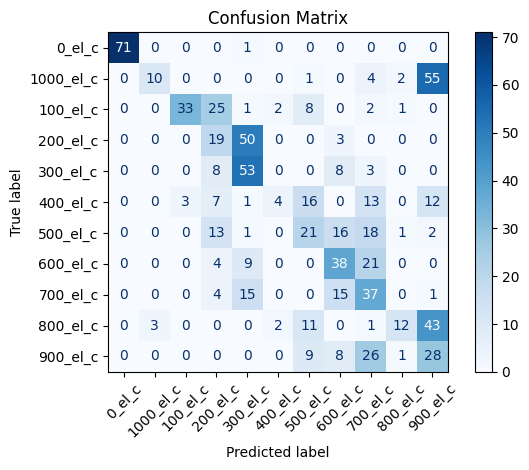

In [34]:
train_loader, test_loader, class_names = load_full_dataset(root_dir)
model, y_pred, y_true = train_resnet_model(train_loader, test_loader, num_classes=len(class_names))
show_confusion_matrix(y_true, y_pred, class_names)
